
### **Ejercicio de simulación final - Señales y Sistemas - 2025 2S**
#### **Estudiante:** Martín Ramírez Espinosa
##### Departamento de Ingeniería Eléctrica, Electrónica y Computación
##### Universidad Nacional de Colombia - Sede Manizales

---

#### **Ejercicios**

1. Descargue 10 segundos de la canción de su preferencia desde youtube, y genere un filtro pasabanda (el usuario debe poder definir las frecuencias de corte) para cada uno de los filtros descritos (el usuario también debe poder fijar los parámetros de diseño de cada filtro). Compare los resultados de los filtros estudiados en este cuaderno tipo IIR para diseño Butterworth, Chebyshev 1, Chebyshev 2, Bessel y Elíptico.

2. Consulte en qué consiste el método de diseño de filtros FIR por ventaneo (Ver función [firwin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html) y [material de apoyo](https://www.programcreek.com/python/example/100540/scipy.signal.firwin)). Realice un cuadro comparativo de las ventajas y desventajas de los filtros IIR y los FIR. Nota: Recuerde que un filtro FIR utiliza solamente raíces tipo ceros, es decir que $a_0=1$, y $a_k=0$ $\forall k\in\{1,2,\dots\}$.

3. Incluya la implementación del filtro `firwin` en el punto 1.

In [18]:
import numpy as np
import shutil
from pathlib import Path
from typing import Tuple, Optional
from yt_dlp import YoutubeDL
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from IPython.display import Audio, display

---

In [19]:
def clear_cache(
        cache_dir: Optional[str] = None  # Path to cache directory
) -> None:                               # No return value
    ''' Clears the cache directory '''
    # Determine cache path (default: ./cache)
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "audio_cache"
    if not cache_path.exists() or not cache_path.is_dir():
        return # Nothing to clear

    # Remove all files and directories in cache, except .gitignore
    for entry in cache_path.iterdir():
        if entry.name == ".gitignore":
            continue
        if entry.is_dir():
            shutil.rmtree(entry)
        else:
            entry.unlink()


def get_audio(
    url: str,                         # YouTube video URL
    start_s: float = 0.0,             # Start time of audio segment [s]
    duration_s: float = 5.0,          # Duration of audio segment [s]
    sample_rate_hz: int = 44100,      # Desired sample rate [Hz]
    cache_dir: Optional[str] = None,  # Path to cache directory
    clean_cache: bool = True,         # Whether to clear cache before downloading
) -> Tuple[np.ndarray, int]:          # (audio samples, sample rate)
    ''' Downloads audio from a YouTube URL and returns a segment as a numpy array '''
    # Setup cache directory
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "audio_cache"
    if clean_cache:
        clear_cache(cache_path)
    cache_path.mkdir(parents=True, exist_ok=True)

    # Download audio using yt-dlp
    ydl_opts = {
        "format": "bestaudio/best",                     # Best audio format
        "outtmpl": str(cache_path / "%(id)s.%(ext)s"),  # Output template
        "quiet": True,                                  # Suppress output
        "no_warnings": True,                            # Suppress warnings
    }

    # Download audio file
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)              # Extract info and download
        audio_file = cache_path / f"{info['id']}.{info['ext']}"  # Path to downloaded audio file

    # Load audio segment using pydub
    segment = AudioSegment.from_file(audio_file)                                       # Load audio file
    start_ms = max(int(start_s * 1000), 0)                                             # Start time in milliseconds
    end_ms = start_ms + int(duration_s * 1000)                                         # End time in milliseconds
    segment = segment[start_ms:end_ms].set_channels(1).set_frame_rate(sample_rate_hz)  # Mono and desired sample rate

    # Convert audio segment to numpy array
    raw = np.asarray(segment.get_array_of_samples())            # Raw audio samples
    samples = raw.astype(np.float32) / np.iinfo(raw.dtype).max  # Normalize to [-1, 1]
    return samples, sample_rate_hz

In [22]:
link = "https://www.youtube.com/watch?v=u6LahTuw02c"

In [21]:
song, f_s = get_audio(link, duration_s=10)

In [23]:
def plot_domains(
    msg_t: np.ndarray,  # Time-domain message signal
    f_s: int,  # Sampling frequency [Hz]
    labels: Optional[
        dict[str, str]
    ] = None,  # Optional {'title', 't_leyend', 'f_leyend'}
) -> None:  # No return value
    """Plots the time and frequency domains of the message signal and plays the audio"""
    if labels is not None:
        expected_keys = {"title", "t_leyend", "f_leyend"}
        if not isinstance(labels, dict) or not expected_keys.issuperset(labels.keys()):
            raise ValueError(
                "labels must be a dict with keys 'title', 't_leyend', 'f_leyend'"
            )
    title = labels.get("title") if labels else None
    t_leyend = labels.get("t_leyend") if labels else None
    f_leyend = labels.get("f_leyend") if labels else None
    # Time domain
    N = len(msg_t)  # Number of samples
    T_s = 1.0 / f_s  # Sampling period [s]
    t = np.linspace(0.0, N * T_s, N, endpoint=False)  # Time vector

    # Frequency domain
    msg_f = fft(msg_t)  # Frequency-domain message signal
    f = fftfreq(N, T_s)[: N // 2]  # Frequency vector

    plt.figure(figsize=(12, 6))
    if title:
        plt.suptitle(title)

    time_plot_kwargs = {"color": "blue"}
    if t_leyend:
        time_plot_kwargs["label"] = t_leyend

    # Time Domain Plot
    plt.subplot(2, 1, 1)
    plt.plot(t, msg_t, **time_plot_kwargs)
    plt.title("Time Domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    if t_leyend:
        plt.legend(loc="upper right")

    freq_plot_kwargs = {"color": "red"}
    if f_leyend:
        freq_plot_kwargs["label"] = f_leyend

    # Frequency Domain Plot
    plt.subplot(2, 1, 2)
    plt.plot(f, 2.0 / N * np.abs(msg_f[0 : N // 2]), **freq_plot_kwargs)
    plt.title("Frequency Domain")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    if f_leyend:
        plt.legend(loc="upper right")

    if title:
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    else:
        plt.tight_layout()
    plt.show()
    # Play audio
    display(Audio(msg_t, rate=f_s))


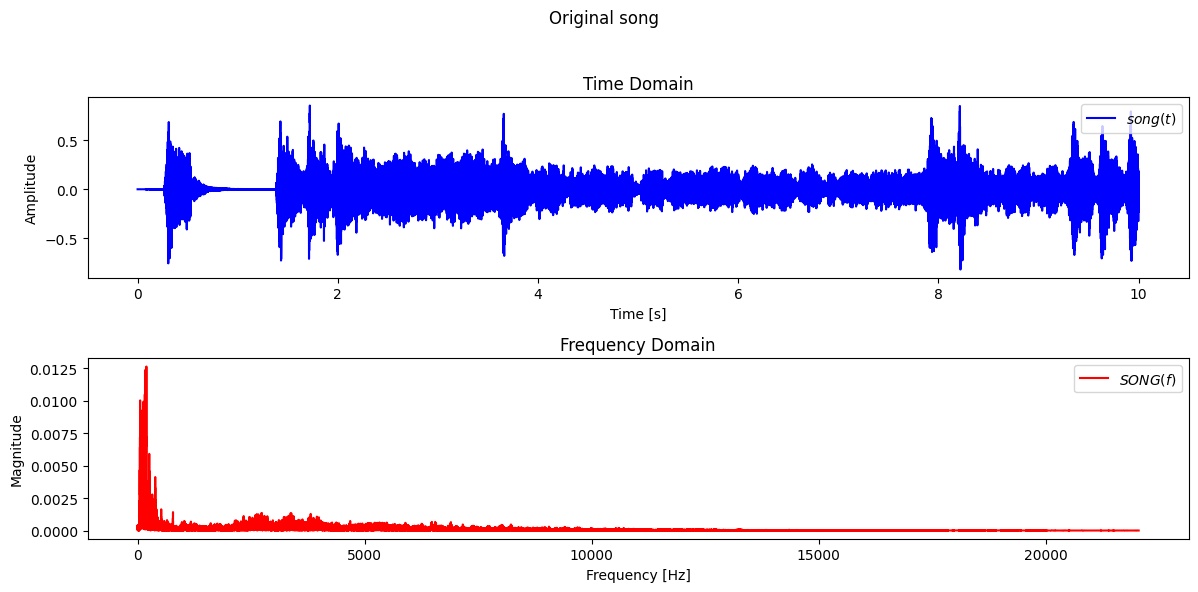

In [24]:
labels = {"title": "Original song", "t_leyend": "$song(t)$", "f_leyend": "$SONG(f)$"}
plot_domains(song, f_s, labels)